In [6]:
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.models import Model
from keras import backend as K
from keras.optimizers import SGD
from keras.layers import Dense, GlobalAveragePooling2D, Input
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing.image import (ImageDataGenerator, Iterator,
                                       array_to_img, img_to_array, load_img)
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras.optimizers import SGD, Adam
import sys, os
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import metrics


os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [7]:
tf.__version__

'2.2.0'

In [8]:
%matplotlib inline

In [9]:
# os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

### Data Generator

In [10]:
train_data_dir = '../data/CollisionData/'

img_width, img_height = 224, 224
nb_train_samples = 730 
nb_validation_samples = 181
epochs = 10
batch_size = 16

if K.image_data_format() == 'channels_first': 
    input_shape = (3, img_width, img_height) 
else: 
    input_shape = (img_width, img_height, 3) 

In [11]:
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    ) # set validation split

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    subset='validation') # set as validation data

Found 730 images belonging to 2 classes.
Found 181 images belonging to 2 classes.


### Model Architecture
ResNet - 50 Base

Using imagenet weights as initialization. The entire architecture is retrainable.

In [26]:
def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = True #change this to False is retraining is not to be done in base layers

    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        # New FC layer, random init
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    # New softmax layer
    predictions = Dense(1, activation='sigmoid')(x) 
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

base_model = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape=input_shape)

class_list = ['CollisionOrClose', 'NoCollision']
FC_LAYERS = [256, 256]
dropout = 0.5

finetune_model = build_finetune_model(base_model, 
                                      dropout=dropout, 
                                      fc_layers=FC_LAYERS, 
                                      num_classes=len(class_list))

In [27]:
adam = Adam(lr=0.00001)
finetune_model.compile(adam, loss='binary_crossentropy', metrics=['accuracy'])

filepath="./checkpoints/" + "ResNet50" + "_model_weights.h5"
checkpoint = ModelCheckpoint(filepath, monitor=["acc"], verbose=1, mode='max')
callbacks_list = [checkpoint]

In [28]:
finetune_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

### Training and Testing

In [29]:
history = finetune_model.fit_generator(train_generator, 
    steps_per_epoch = nb_train_samples // batch_size, 
    epochs = epochs, validation_data = validation_generator, 
    validation_steps = nb_validation_samples // batch_size, shuffle=True,) 

Epoch 1/10
45/45 [==============================] - 16s 355ms/step - loss: 0.8658 - accuracy: 0.6863 - val_accuracy: 0.6364 - val_loss: 0.6885
Epoch 2/10
45/45 [==============================] - 15s 339ms/step - loss: 0.4410 - accuracy: 0.8095 - val_accuracy: 0.2330 - val_loss: 1.0236
Epoch 3/10
45/45 [==============================] - 15s 340ms/step - loss: 0.3584 - accuracy: 0.8473 - val_accuracy: 0.2330 - val_loss: 0.9676
Epoch 4/10
45/45 [==============================] - 15s 340ms/step - loss: 0.2939 - accuracy: 0.8754 - val_accuracy: 0.5568 - val_loss: 0.6896
Epoch 5/10
45/45 [==============================] - 15s 335ms/step - loss: 0.2755 - accuracy: 0.8824 - val_accuracy: 0.7045 - val_loss: 0.6115
Epoch 6/10
45/45 [==============================] - 15s 341ms/step - loss: 0.2527 - accuracy: 0.9090 - val_accuracy: 0.7386 - val_loss: 0.5851
Epoch 7/10
45/45 [==============================] - 16s 345ms/step - loss: 0.2159 - accuracy: 0.9216 - val_accuracy: 0.6648 - val_loss: 0.6070

### Performance

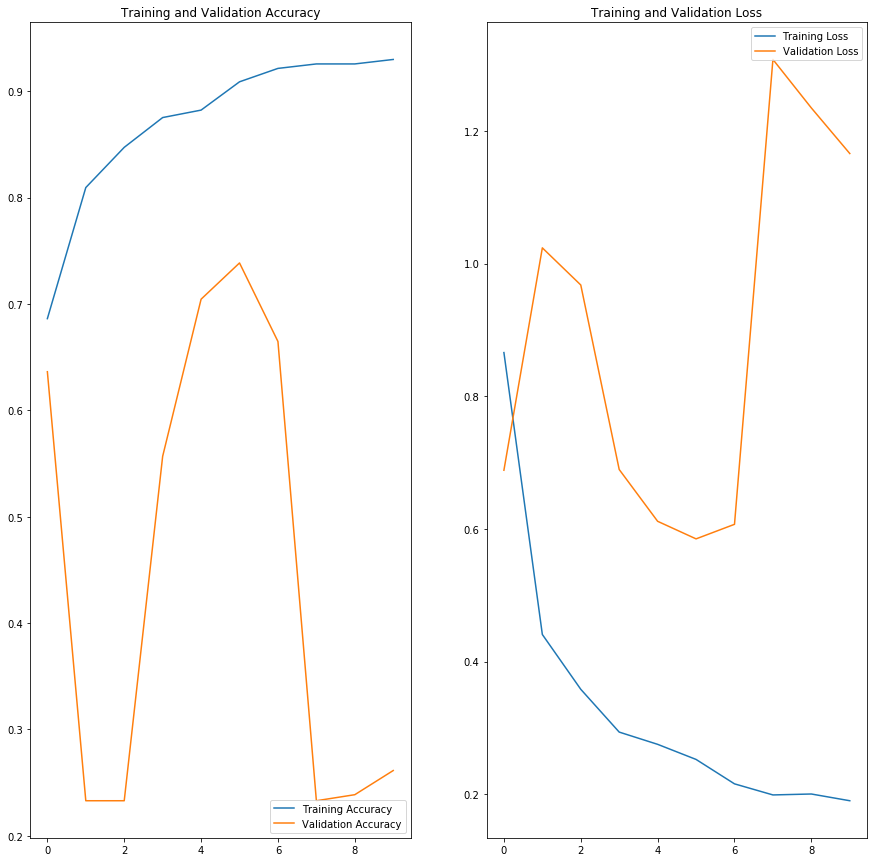

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [31]:
from sklearn.metrics import confusion_matrix


probabilities = finetune_model.predict_generator(generator=validation_generator)
print(probabilities)

[[0.17537397]
 [0.23941326]
 [0.255015  ]
 [0.1514965 ]
 [0.6167443 ]
 [0.21386255]
 [0.34417588]
 [0.40383184]
 [0.2933238 ]
 [0.2890719 ]
 [0.11189432]
 [0.15587898]
 [0.1921987 ]
 [0.20466779]
 [0.24605235]
 [0.20302728]
 [0.20797461]
 [0.12570272]
 [0.17437811]
 [0.31984308]
 [0.12498745]
 [0.17463373]
 [0.47503656]
 [0.16277516]
 [0.2775283 ]
 [0.3698838 ]
 [0.43986964]
 [0.17343277]
 [0.27885532]
 [0.16535224]
 [0.14883839]
 [0.12880445]
 [0.17123564]
 [0.5445628 ]
 [0.10213012]
 [0.36639214]
 [0.37399963]
 [0.23356658]
 [0.35622892]
 [0.18131988]
 [0.3737193 ]
 [0.31130445]
 [0.30260122]
 [0.3472563 ]
 [0.46239227]
 [0.27331403]
 [0.33730367]
 [0.22197379]
 [0.16236751]
 [0.25704098]
 [0.26380658]
 [0.14004569]
 [0.13446124]
 [0.47413272]
 [0.2915449 ]
 [0.36430112]
 [0.13975196]
 [0.16518946]
 [0.43308768]
 [0.5343132 ]
 [0.33972406]
 [0.37104443]
 [0.3090166 ]
 [0.32836524]
 [0.15008467]
 [0.26010227]
 [0.27368098]
 [0.26788384]
 [0.40293613]
 [0.40521833]
 [0.19304277]
 [0.13

In [32]:
y_true = validation_generator.classes
y_pred = probabilities > 0.5
class_labels = list(validation_generator.class_indices.keys())  

In [33]:
report = metrics.classification_report(y_true, y_pred, target_names=class_labels)
print(report)  

                  precision    recall  f1-score   support

     NoCollision       0.22      0.95      0.36        41
CollisionOrClose       0.33      0.01      0.01       140

        accuracy                           0.22       181
       macro avg       0.28      0.48      0.19       181
    weighted avg       0.31      0.22      0.09       181



In [21]:
mat = confusion_matrix(y_true, y_pred)
print(mat)

[[ 41   0]
 [ 10 130]]


### Analyze Results

In [22]:
def plotImages1(images_arr, y1, y2, row_size):
    fig, axes = plt.subplots(1, row_size, figsize=(20,20))
    axes = axes.flatten()
    for img, l, p, ax in zip(images_arr, y1, y2, axes):
        ax.imshow(img)
        ax.set_title("Label:"+str(int(l))+", Pred:"+str(int(p)))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

<Figure size 1440x1440 with 0 Axes>

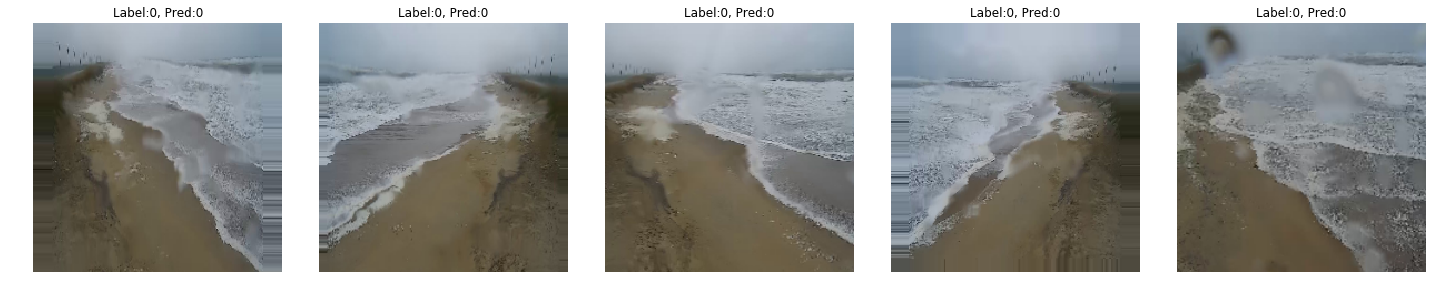

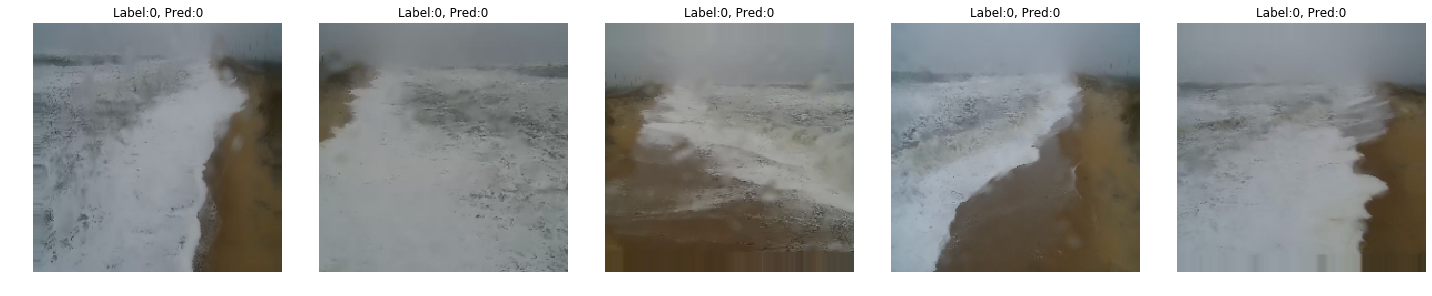

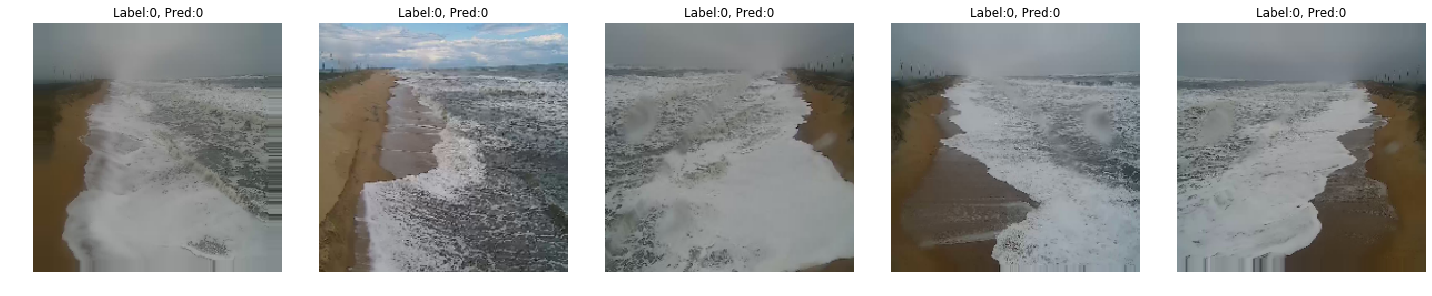

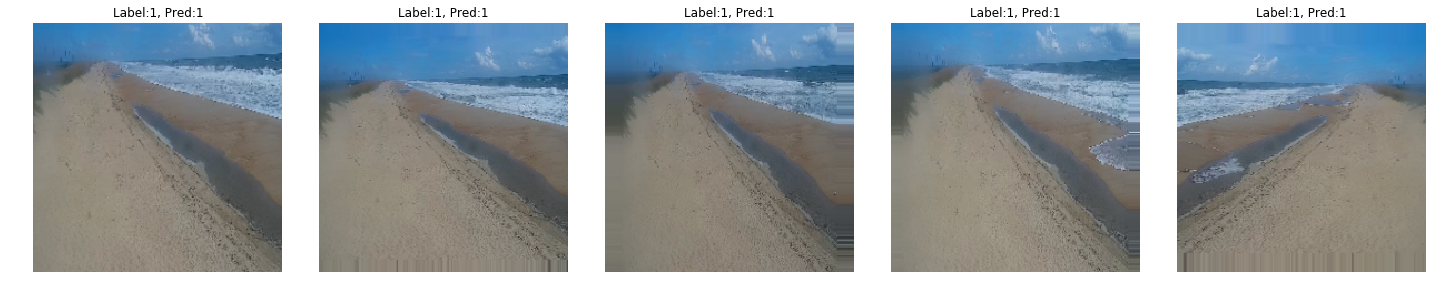

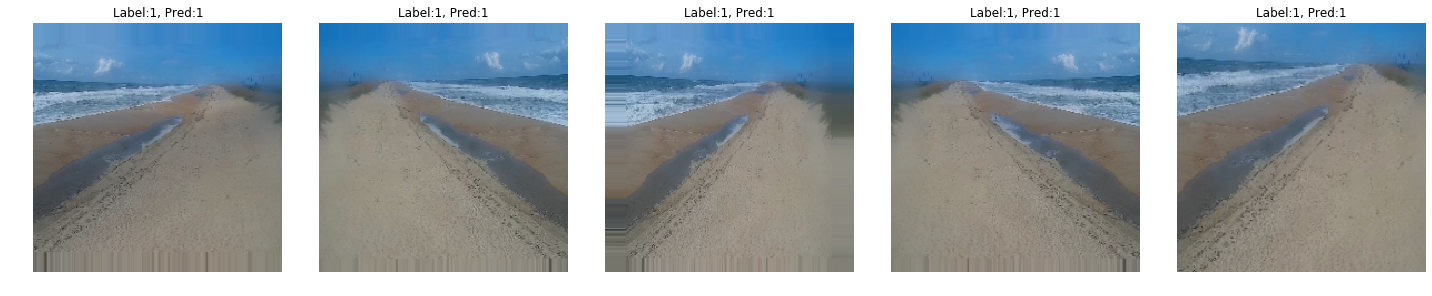

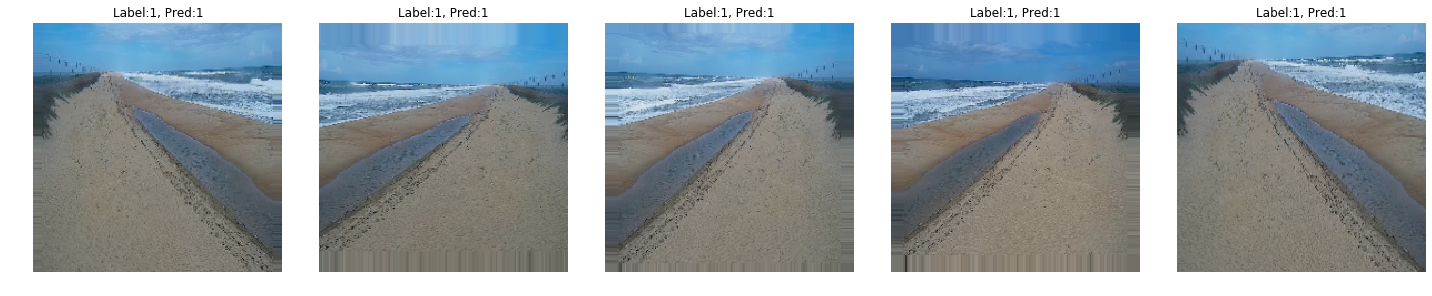

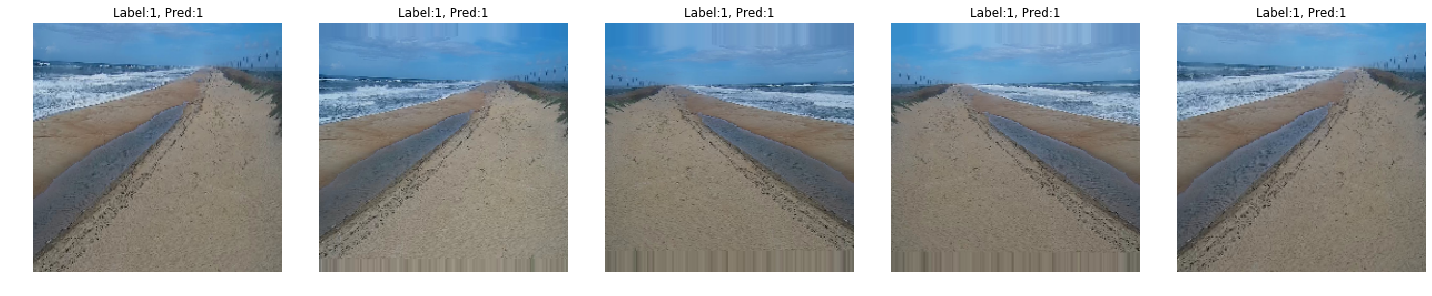

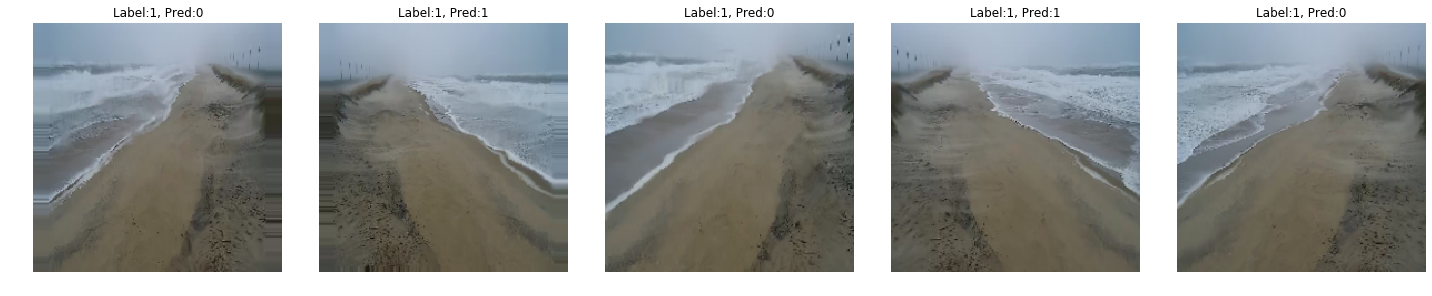

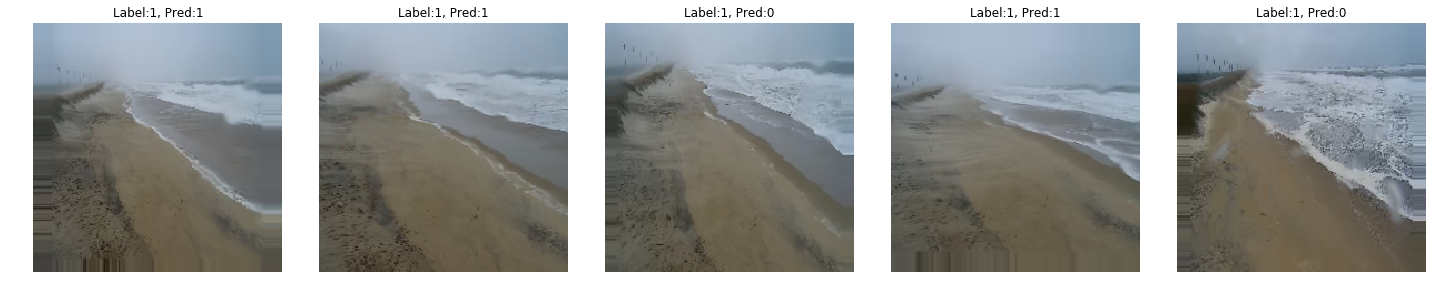

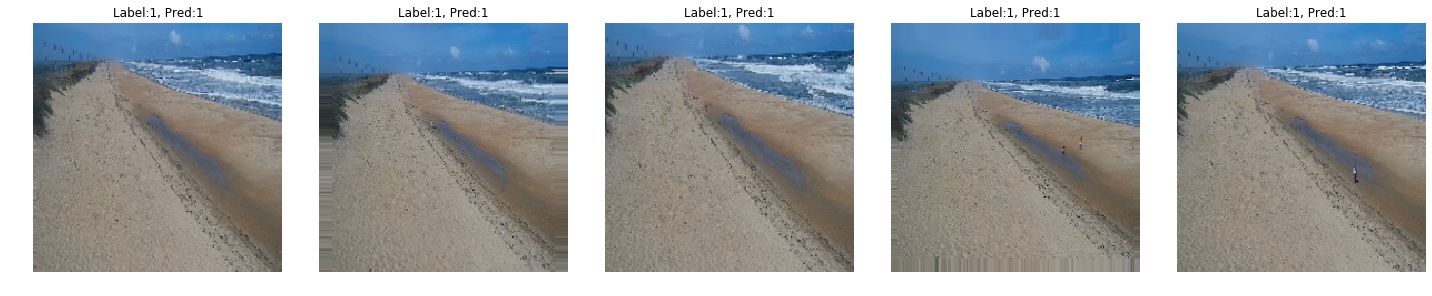

In [23]:
cnt = 0
row_size = 5
validation_generator.reset()
fig=plt.figure(figsize=(20,20))

ax = []
for i in range(10):
    x,y = next(validation_generator)
    img = x[:row_size]
    y_label = y[:row_size]
    y_predicted = y_pred[cnt:cnt+row_size]
    plotImages1(img, y_label, y_predicted, row_size)
    cnt += 16

In [24]:
labels = (validation_generator.class_indices)

In [25]:
labels

{'CollisionOrClose': 0, 'NoCollision': 1}